In [1]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import georaster
from importlib import reload
# import cv2
from affine import Affine
from pyproj import Proj
from pyproj import transform

# from osgeo import gdal
# from osgeo import osr

import utils

from mpl_toolkits.basemap import Basemap

In [2]:
# !gdalinfo livingston.tif

In [3]:
FPATH = 'livingston.tif'
img = rasterio.open(FPATH)
print(f"shape: {img.shape}")
print(f"block_shapes: {img.block_shapes}")
print(f"crs: {img.crs}")
print(f"count (bands): {img.count}")
print(f"indexes: {img.indexes}")
print(f"driver: {img.driver}")
print(f"is_tiled: {img.is_tiled}")
print(f"transform: {img.transform}")
print(f"bounds: {img.bounds}")
print(f"scales: {img.scales}")
print(f"profile: {img.profile}")

# print(dir(img))

shape: (68398, 69395)
block_shapes: [(256, 256), (256, 256), (256, 256)]
crs: EPSG:2898
count (bands): 3
indexes: (1, 2, 3)
driver: GTiff
is_tiled: True
transform: | 2.00, 0.00, 13176690.03|
| 0.00,-2.00, 471033.21|
| 0.00, 0.00, 1.00|
bounds: BoundingBox(left=13176690.03028731, bottom=334237.2135082334, right=13315480.03028731, top=471033.2135082334)
scales: (1.0, 1.0, 1.0)
profile: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 80.0, 'width': 69395, 'height': 68398, 'count': 3, 'crs': CRS.from_epsg(2898), 'transform': Affine(2.0, 0.0, 13176690.03028731,
       0.0, -2.0, 471033.2135082334), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'interleave': 'pixel'}


In [4]:
dir(img)
img.res

(2.0, 2.0)

In [5]:

def get_latlon(trnsfrm, row, col, proj=img.crs):
    """ TODO 
    
    https://gis.stackexchange.com/questions/129847/obtain-coordinates-and-corresponding-pixel-values-from-geotiff-using-python-gdal
    """
    # upper-left pixel corner affine transform
    p1 = Proj(proj)

    # Get affine transform for pixel centres
    T1 = trnsfrm * Affine.translation(0.5, 0.5)

    # Project all longitudes, latitudes
    p2 = Proj(proj='latlong', datum='WGS84')

    # get pixel point values from position in
    # matrix
    x, y = img.xy(row, col)
    

    lon, lat = transform(p1, p2, x, y)
    return lat, lon


## FOR (0,0) EXPECT: (42.792356570263266, -84.16796309552618)

lat, lon = get_latlon(img.transform, 0, 0)
print(lat, lon)

42.792356570263266 -84.16796309552618


In [6]:
def get_window(img, x_offset=0, y_offset=0, 
               side_len=1000):
    """ TODO """
    window = rasterio.windows.Window(x_offset, y_offset, 
                                     side_len, side_len)
    subset = img.read(window=window)    
    return subset, window

In [7]:
print(f"shape: {img.shape}")

shape: (68398, 69395)


row, column: 30000, 30000
lat, lon: 42.62710937950923, -83.9455346157804

row, column: 30100, 30000
lat, lon: 42.62656057417139, -83.94553833312527



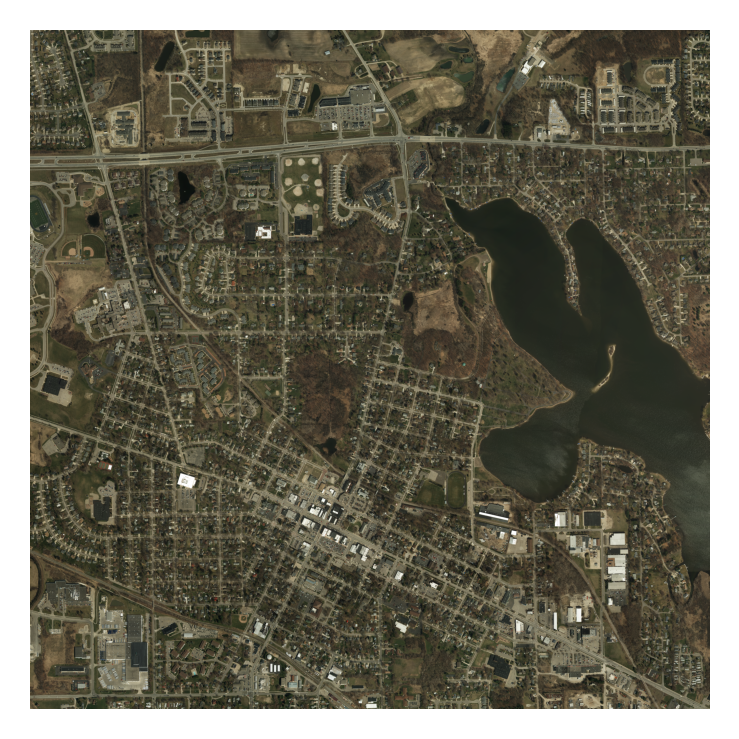

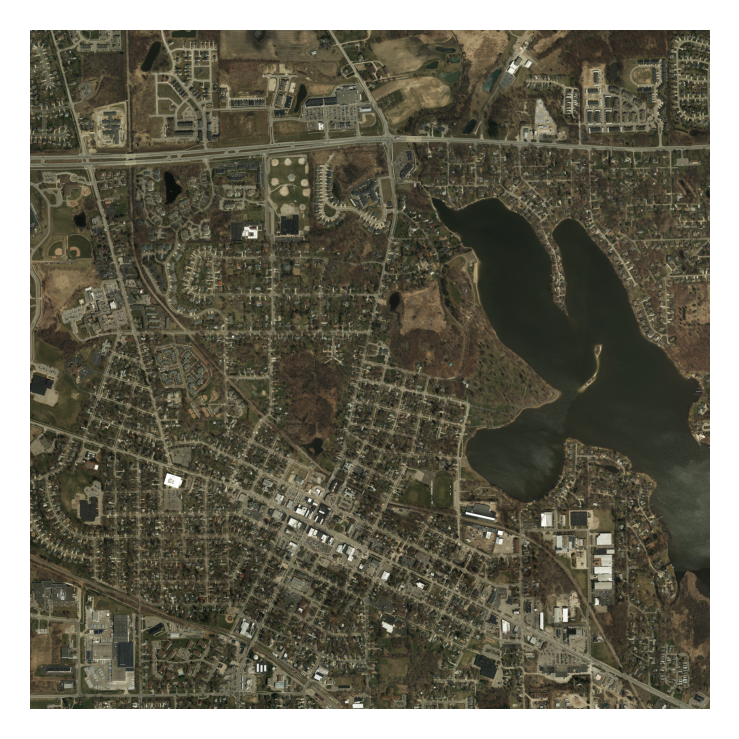

In [8]:
"""
plot subsets
"""

img_row = 30000
img_col = 30000

side_len = 5000
N_RANGE = 2

for i in range(N_RANGE):

    _x = img_row + (i * 100)
    _y = img_col

    clip, win = get_window(img, x_offset=_x, y_offset=_y, side_len=side_len)

    # get window_specific transformation
    win_transform = img.window_transform(win)
    # print(type(win_transform))

    lat, lon = get_latlon(win_transform, _x, _y)
    print(f"row, column: {_x}, {_y}")
    print(f"lat, lon: {lat}, {lon}")
    print()

    fig = utils.build_fig(size=(3,3), axis_off=True)
    plt.imshow(np.moveaxis(clip, 0, 2))
    plt.savefig(f"TEST_{lat}_{lon}.png")

42.44760164765848 -83.70590270199615


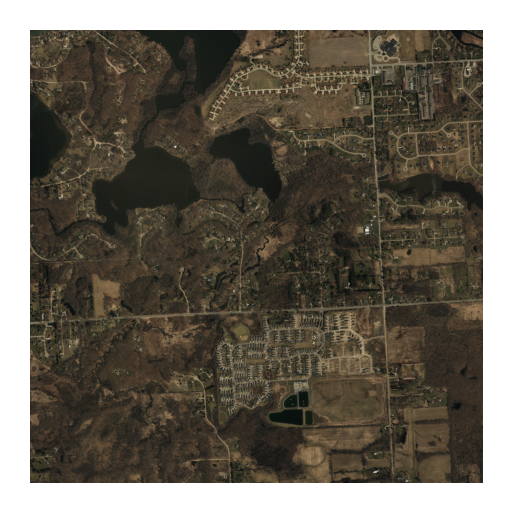

In [25]:
class MosiacBuilder():
    """ a class to manage building mosaics """

    import numpy as np
    import pandas as pd
    import rasterio
    import matplotlib.pyplot as plt
    from affine import Affine
    from pyproj import Proj
    from pyproj import transform

    def __init__(self, filepath):
        """ TODO """
        self.filepath = filepath
        self.src = rasterio.open(self.filepath)
        self.shape = self.src.shape
        self.NAME = filepath.split(".")[0]
        self.PAD_VALUE = 255


    def get_window(self, row, col, side_len, return_win=False):
        """ A method to get a subset of a given raster given 
        row/column offsets from (0,0). 

        ARGS:
            - row (int): offset along latitude, y axis offset'
            - col (int): offset along longitude, x axis offset
            - side_len (int): how large is the image?
            - return_win (bool): if True, return the window object

        RETURNS:
            - subset (np.array): a window from the original raster. NOTE: by
                default this array is channels first, RGB: (3, side_len, side_len)

            - window (affine.Affine): DEPENDS ON BOOL FLAG: `return_win` set to True. 
                transformation associated with top-left corner
                of `subset`. Used for translation to lat/lon
        """
        window = rasterio.windows.Window(col, row, side_len, side_len)
        subset = self.src.read(window=window)    

        if return_win:
            return subset, window
        else: 
            return subset


    def get_latlon_point(self, row, col):
        """ Get lat andf lon from a single point 
        
        ARGS:
            - col (int): offset along longitude, x axis offset
            - row (int): offset along latitude, y axis offset'

        RETURNS:
            - lat (float): latitude
            - lon (float): longitude
        """
        p1 = Proj(self.src.crs)
        window = rasterio.windows.Window(col, row, 1, 1)
        trnsfrm = self.src.window_transform(window)
        T1 = trnsfrm * Affine.translation(0.5, 0.5)
        p2 = Proj(proj='latlong', datum='WGS84')
        x, y = self.src.xy(row, col)
        lon, lat = transform(p1, p2, x, y)
        return lat, lon

    
    def build_mosaic(self, side_len=1000):
        """ A method to build a set number of SQUARE
        images with a given side length from a raster.side_len
        
        ARGS:
            - side_len (int): the dimension of a side square tile
        
        RETURNS:
            - tiles (list of np.array): a list of subsets
            - center_coords (list of list): a list of [lat, lon] coordinates for the
                center of an image
        """

        tiles = []
        center_coords = []

        row_idx = 0

        for i in range(int(self.shape[0] / side_len)+1):
            col_idx = 0
            for j in range(int(self.shape[1] / side_len)+1):

                # get clip
                clip = self.get_window(row_idx, col_idx, side_len)
                tiles.append(clip)

                # get center lat/lon
                lat, lon = self.get_latlon_point(row_idx + side_len // 2, col_idx + side_len // 2)

                center_coords.append([lat, lon])

                # increment counters
                col_idx += side_len
            row_idx += side_len

        return tiles, center_coords

ROW = 60000
COL = 60000
SIDE_LEN = 5000

livingston = MosiacBuilder('livingston.tif')

clip = livingston.get_window(ROW, COL, SIDE_LEN)
lat, lon = livingston.get_latlon_point(ROW + SIDE_LEN // 2, COL + SIDE_LEN // 2)
print(lat, lon)

fig = utils.build_fig(size=(2,2), axis_off=True)
plt.imshow(np.moveaxis(clip, 0, 2))
plt.savefig(f"TEST_{lat}_{lon}.png")

In [10]:
%%time
tiles, center_coords = livingston.build_mosaic()

4830

[42.437107603042435, -83.7949265834009]


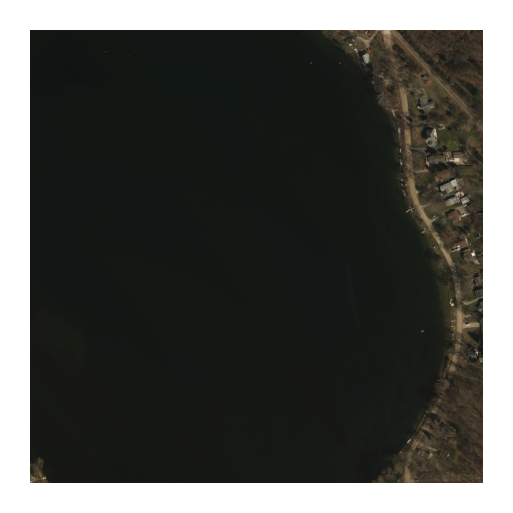

In [24]:
IDX = -300

print(center_coords[IDX])
fig = utils.build_fig(size=(2,2), axis_off=True)
plt.imshow(np.moveaxis(tiles[IDX], 0, 2))